# 1. Import the dependencies and pipeline modules

In [1]:
# 基础依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pipeline各模块
from data_loader import DataLoader
from data_preprocessor import DataPreprocessor
from feature_selector import FeatureSelector
from model_trainer import ModelTrainer
from pipeline_config import MODEL_CONFIG

# 2. Data loading and display

In [2]:
# ===============================================================
#          步骤 1: 原始数据加载与快速预览
# ===============================================================
from data_loader import DataLoader

loader = DataLoader()
print("🔄 正在加载原始数据...")
raw_data = loader.merge_data() 
def any_diabetes(row):
    return any(str(row[diag]).strip().startswith('250') for diag in ['diag_1', 'diag_2', 'diag_3'])

raw_data = raw_data[raw_data.apply(any_diabetes, axis=1)]
print(f"📊 原始数据维度: {raw_data.shape}")
print("\\n📋 原始数据预览:")
display(raw_data.head())

INFO:data_loader:Merging all data tables...
INFO:data_loader:Loading diabetic data...


🔄 正在加载原始数据...


INFO:data_loader:Diabetic data loaded: (101766, 50)
INFO:data_loader:Loading ID mapping data...
INFO:data_loader:ID mapping data loaded: (67, 2)
INFO:data_loader:ID mapping data split into three tables
INFO:data_loader:Data merged successfully: (101766, 51)


📊 原始数据维度: (38024, 51)
\n📋 原始数据预览:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,25,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,3,?,?,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,2,?,?,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,2,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## 2.1 保留首次入院记录

为了准确预测首次30天内再入院，我们只保留每个患者的第一次入院记录。这可以防止同一患者的多次再入院记录对模型产生偏见。后续的所有分析都将基于这个筛选后的数据集。

In [3]:
print(f"处理前总记录数: {len(raw_data)}")
print(f"处理前独立患者数: {raw_data['patient_nbr'].nunique()}")

# 按encounter_id排序，确保第一次入院记录在前
df_sorted = raw_data.sort_values(by='encounter_id')

# 删除重复的患者记录，只保留第一次
# 注意：我们将结果重新赋值给raw_data，以便后续单元格使用筛选后的数据
raw_data = df_sorted.drop_duplicates(subset='patient_nbr', keep='first')

print(f"\n处理后总记录数: {len(raw_data)}")
print(f"处理后独立患者数: {raw_data['patient_nbr'].nunique()}")

处理前总记录数: 38024
处理前独立患者数: 31188

处理后总记录数: 31188
处理后独立患者数: 31188


## 2.2 移除逻辑上无法再入院的患者

根据数据集的说明，部分 `discharge_disposition_id` 代表患者已经去世或被送往临终关怀机构，这些患者在生理上不可能再次入院。为了避免模型产生偏见，我们需要将这些记录移除。

In [4]:
# 定义代表去世或临终关怀的ID
hospice_or_death_ids = [11, 13, 14, 19, 20, 21]

print(f"处理前记录数: {len(raw_data)}")

# 筛选出不包含这些ID的记录
raw_data = raw_data[~raw_data['discharge_disposition_id'].isin(hospice_or_death_ids)]

print(f"移除不可能再入院的患者后，剩余记录数: {len(raw_data)}")

处理前记录数: 31188
移除不可能再入院的患者后，剩余记录数: 30909


In [5]:
import pandas as pd

# 加载数据
df = pd.read_csv('diabetic_data.csv')

# 定义判断是否为糖尿病诊断（ICD-9 250.xx）
def is_diabetes(code):
    try:
        code_str = str(code).strip()
        return code_str.startswith('250')
    except:
        return False

# 检查每条记录的三个诊断是否全是糖尿病
any_diag_diabetes = df.apply(
    lambda row: any([
        is_diabetes(row['diag_1']),
        is_diabetes(row['diag_2']),
        is_diabetes(row['diag_3'])
    ]),
    axis=1
)

# 输出统计结果
num_any_diabetes = any_diag_diabetes.sum()
total_records = len(df)
print(f"三个诊断有糖尿病的记录数: {num_any_diabetes}")
print(f"占总记录数的比例: {num_any_diabetes / total_records:.4%}")

# 展示前几条全为糖尿病的记录
display(df[any_diag_diabetes].head())

三个诊断有糖尿病的记录数: 38024
占总记录数的比例: 37.3641%


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
import pandas as pd

# 加载数据
df = pd.read_csv('diabetic_data.csv')

# 定义判断是否为糖尿病诊断（ICD-9 250.xx）
def is_diabetes(code):
    try:
        code_str = str(code).strip()
        return code_str.startswith('250')
    except:
        return False

# 检查每条记录的主诊断是是糖尿病
all_diag_diabetes = df.apply(
    lambda row: all([
        is_diabetes(row['diag_1']),
        
    ]),
    axis=1
)

# 输出统计结果
num_all_diabetes = all_diag_diabetes.sum()
total_records = len(df)
print(f"主诊断为糖尿病的记录数: {num_all_diabetes}")
print(f"占总记录数的比例: {num_all_diabetes / total_records:.4%}")

# 展示前几条全为糖尿病的记录
display(df[all_diag_diabetes].head())

主诊断为糖尿病的记录数: 8757
占总记录数的比例: 8.6050%


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
10,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
52,590346,37746639,AfricanAmerican,Female,[40-50),?,1,6,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
56,630342,93232917,AfricanAmerican,Female,[50-60),?,3,6,2,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
60,676422,63754317,AfricanAmerican,Female,[70-80),?,1,1,7,4,...,No,Steady,No,No,No,No,No,No,Yes,>30


# 3. Data Preprocessing and EDA

In [7]:
preprocessor = DataPreprocessor()
df = preprocessor.apply_feature_engineering(raw_data)
df = preprocessor.prepare_target_variable(df)

print(f"特征工程后数据维度: {df.shape}")
display(df.head())

INFO:data_preprocessor:Applying feature engineering...
INFO:data_preprocessor:Original number of encounters: 30909
INFO:data_preprocessor:Encounters after keeping first admission: 30909
INFO:data_preprocessor:Removed 0 records for hospice/death dispositions.
INFO:data_preprocessor:Encounters after removing hospice/death: 30909
INFO:data_preprocessor:Handling missing values based on notebook's standard...
INFO:data_preprocessor:Replaced '?' with NaN.
INFO:data_preprocessor:🔴 Dropped columns with >50.0% missing: ['weight', 'max_glu_serum', 'A1Cresult']
INFO:data_preprocessor:🟡 Filling specified columns with 'Unknown': ['medical_specialty', 'payer_code', 'race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
INFO:data_preprocessor:✅ All missing values have been handled successfully.
INFO:data_preprocessor:Creating age-related features...
INFO:data_preprocessor:Creating diagnosis-related features...
INFO:data_preprocessor:Creatin

特征工程后数据维度: (30909, 56)


,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,discharge_disposition_desc,admission_source_desc,age_midpoint,age_group,diag_1_category,diag_2_category,diag_3_category,comorbidity,encounter_index,readmitted_binary
4,16680,42519267,Caucasian,Male,[40-50),1,1,Unknown,Unknown,51,...,Discharged to home,Emergency Room,65,40-50,neoplasms,neoplasms,diabetes,2,1,0
10,28236,89869032,AfricanAmerican,Female,[40-50),1,9,Unknown,Unknown,47,...,Discharged to home,Emergency Room,65,40-50,diabetes,circulatory,injuries,2,1,0
5,35754,82637451,Caucasian,Male,[50-60),1,3,Unknown,Unknown,31,...,Discharged to home,Clinic Referral,80,50-60,circulatory,circulatory,diabetes,2,1,0
12,40926,85504905,Caucasian,Female,[40-50),3,7,Unknown,Family/GeneralPractice,60,...,Discharged/transferred to SNF,Emergency Room,65,40-50,circulatory,diabetes,diabetes,2,1,1
7,63768,114882984,Caucasian,Male,[70-80),1,5,Unknown,Unknown,73,...,Discharged to home,Emergency Room,110,70-80,circulatory,respiratory,diabetes,2,1,0


## 3.1 Missuing data handling

In [8]:
# 3.1 基础缺失值统计
print("=== 基础缺失值统计 ===")
missing_counts = raw_data.isnull().sum()
missing_percentage = (missing_counts / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"总共有 {len(missing_df)} 个列存在缺失值")
display(missing_df)

=== 基础缺失值统计 ===
总共有 5 个列存在缺失值


,Column,Missing_Count,Missing_Percentage
20,max_glu_serum,29201,94.474101
21,A1Cresult,24149,78.129347
48,admission_type_desc,2099,6.790902
50,admission_source_desc,2050,6.632372
49,discharge_disposition_desc,1280,4.141189


In [9]:
# 3.2 检查特殊字符 '?' 表示的缺失值
print("=== 特殊字符 '?' 统计 ===")
question_mark_counts = (raw_data == '?').sum()
question_mark_percentage = (question_mark_counts / len(raw_data)) * 100

question_mark_df = pd.DataFrame({
    'Column': question_mark_counts.index,
    'Question_Mark_Count': question_mark_counts.values,
    'Question_Mark_Percentage': question_mark_percentage.values
})
question_mark_df = question_mark_df[question_mark_df['Question_Mark_Count'] > 0].sort_values('Question_Mark_Percentage', ascending=False)

print(f"总共有 {len(question_mark_df)} 个列包含 '?' 字符")
display(question_mark_df)

=== 特殊字符 '?' 统计 ===
总共有 7 个列包含 '?' 字符


,Column,Question_Mark_Count,Question_Mark_Percentage
5,weight,30131,97.482934
8,payer_code,14171,45.847488
9,medical_specialty,13892,44.944838
18,diag_3,1108,3.584716
2,race,842,2.724126
17,diag_2,222,0.718237
16,diag_1,4,0.012941


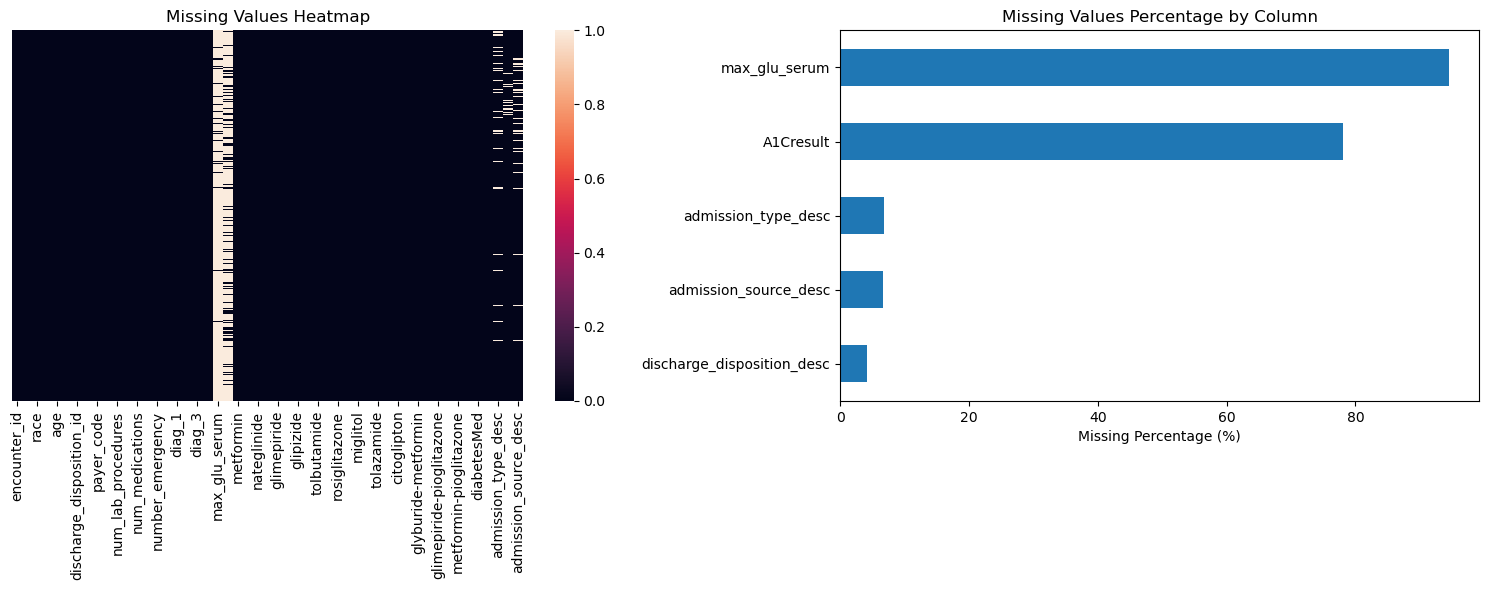

In [10]:
# 3.3 缺失值可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 缺失值热力图
missing_data = raw_data.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# 缺失值百分比条形图
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=True)
missing_percentage_sorted.plot(kind='barh', ax=axes[1])
axes[1].set_title('Missing Values Percentage by Column')
axes[1].set_xlabel('Missing Percentage (%)')

plt.tight_layout()
plt.show()

In [11]:
# 3.4 缺失值处理决策（与Pipeline逻辑完全一致）
print("=== 缺失值处理决策（与Pipeline逻辑一致） ===")
print("基于data_preprocessor.py中的处理标准，我们生成以下决策表：")
print()

# --- 为了准确分析，先模拟pipeline的第一步：将'?'替换为NaN ---
analysis_df = raw_data.replace('?', np.nan)
missing_percentage = (analysis_df.isnull().sum() / len(analysis_df)) * 100

# --- 定义与pipeline完全一致的阈值和填充列 ---
drop_missing_threshold = 50.0
cols_to_fill_with_unknown = [
    'medical_specialty', 'payer_code', 'race',
    'diag_1', 'diag_2', 'diag_3',
    'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc'
]

# --- 生成与pipeline行为一致的决策表 ---
decision_data = []
all_missing_cols_df = missing_percentage[missing_percentage > 0]

for col, percentage in all_missing_cols_df.items():
    if percentage > drop_missing_threshold:
        action = "删除"
        reason = f"缺失率 ({percentage:.1f}%) > {drop_missing_threshold}%"
    elif col in cols_to_fill_with_unknown:
        action = "保留, 用'Unknown'填充"
        reason = f"预定义的填充列"
    else:
        action = "保留, 未指定处理"
        reason = "缺失率低但未在填充列表中"

    decision_data.append([col, f"{percentage:.1f}%", action, reason])

decision_df = pd.DataFrame(decision_data, columns=['列名', '缺失率', '处理方式', '原因'])
decision_df = decision_df.sort_values('缺失率', ascending=False)

print("📋 缺失值处理决策表 (与Pipeline同步):")
display(decision_df)

=== 缺失值处理决策（与Pipeline逻辑一致） ===
基于data_preprocessor.py中的处理标准，我们生成以下决策表：

📋 缺失值处理决策表 (与Pipeline同步):


,列名,缺失率,处理方式,原因
1,weight,97.5%,删除,缺失率 (97.5%) > 50.0%
7,max_glu_serum,94.5%,删除,缺失率 (94.5%) > 50.0%
8,A1Cresult,78.1%,删除,缺失率 (78.1%) > 50.0%
9,admission_type_desc,6.8%,"保留, 用'Unknown'填充",预定义的填充列
11,admission_source_desc,6.6%,"保留, 用'Unknown'填充",预定义的填充列
2,payer_code,45.8%,"保留, 用'Unknown'填充",预定义的填充列
3,medical_specialty,44.9%,"保留, 用'Unknown'填充",预定义的填充列
10,discharge_disposition_desc,4.1%,"保留, 用'Unknown'填充",预定义的填充列
6,diag_3,3.6%,"保留, 用'Unknown'填充",预定义的填充列
0,race,2.7%,"保留, 用'Unknown'填充",预定义的填充列


## 3.2 EDA

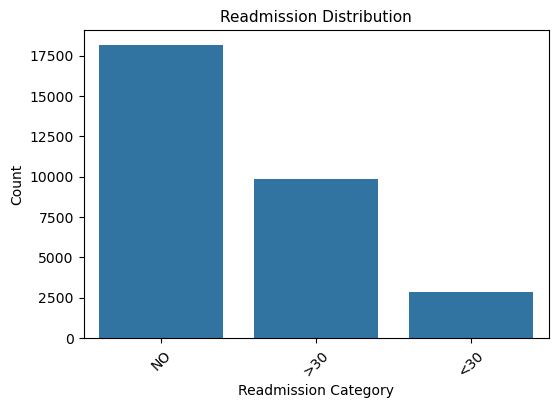

readmitted
NO     18171
>30     9880
<30     2858
Name: count, dtype: int64
No missing values found.
The average age of patients is: 89.49 years
Average stay at hospital by Age Group In Days
age_group
0-10      2.533333
10-20     2.695825
20-30     3.302013
30-40     3.431533
40-50     3.676035
50-60     3.718957
60-70     3.888124
70-80     3.995450
80-90     4.263158
90-100    4.266019
Name: time_in_hospital, dtype: float64


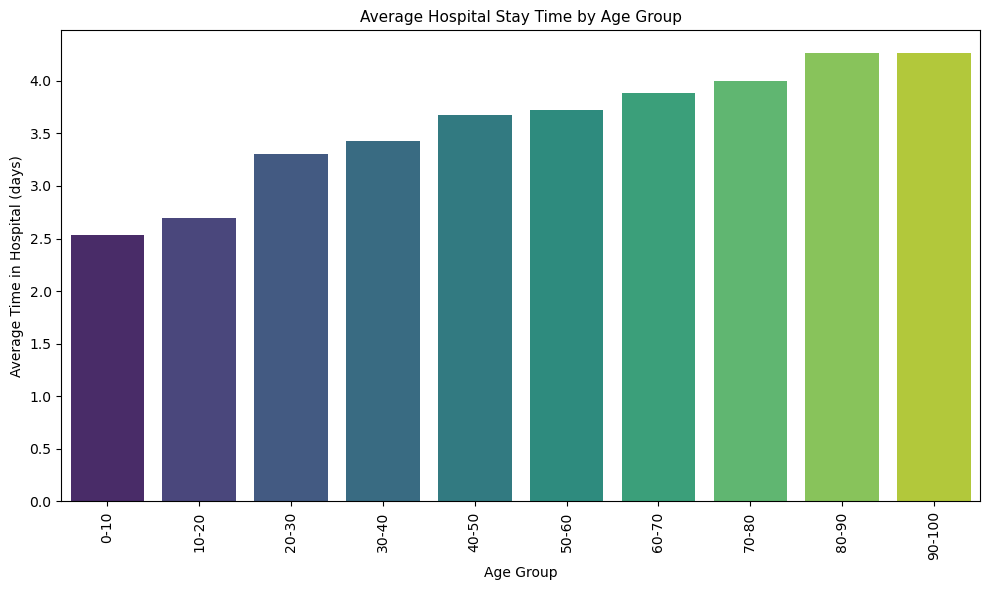

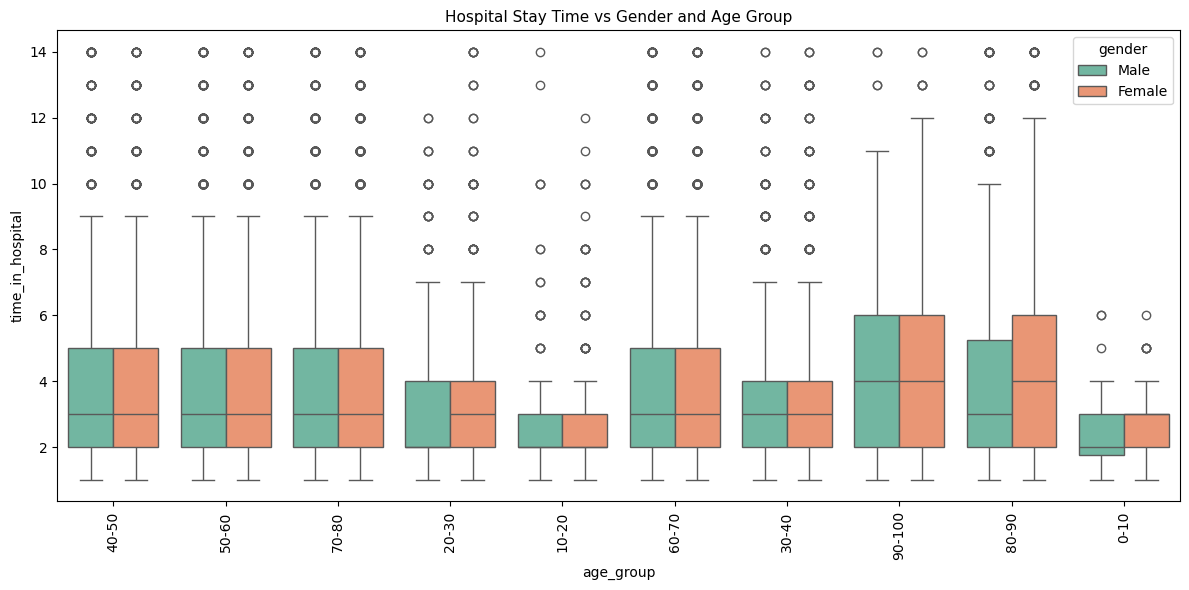

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


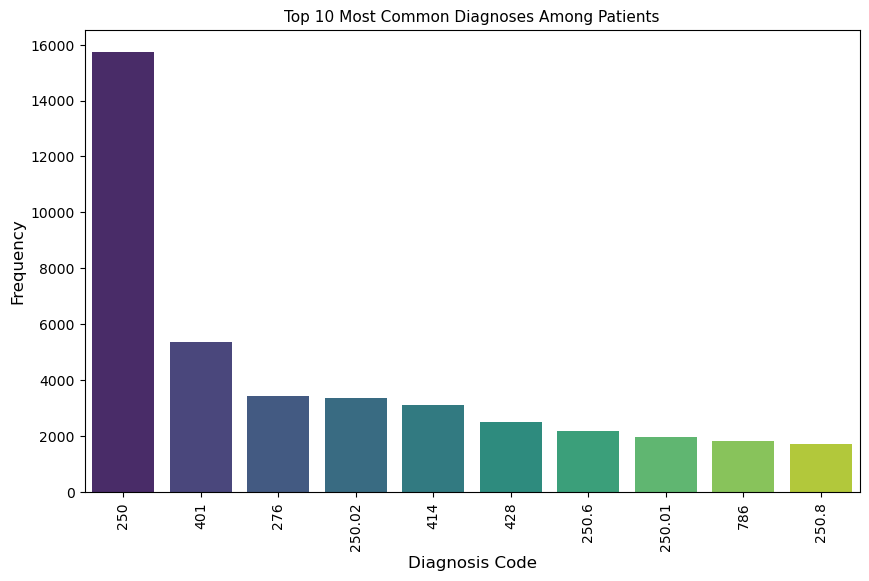

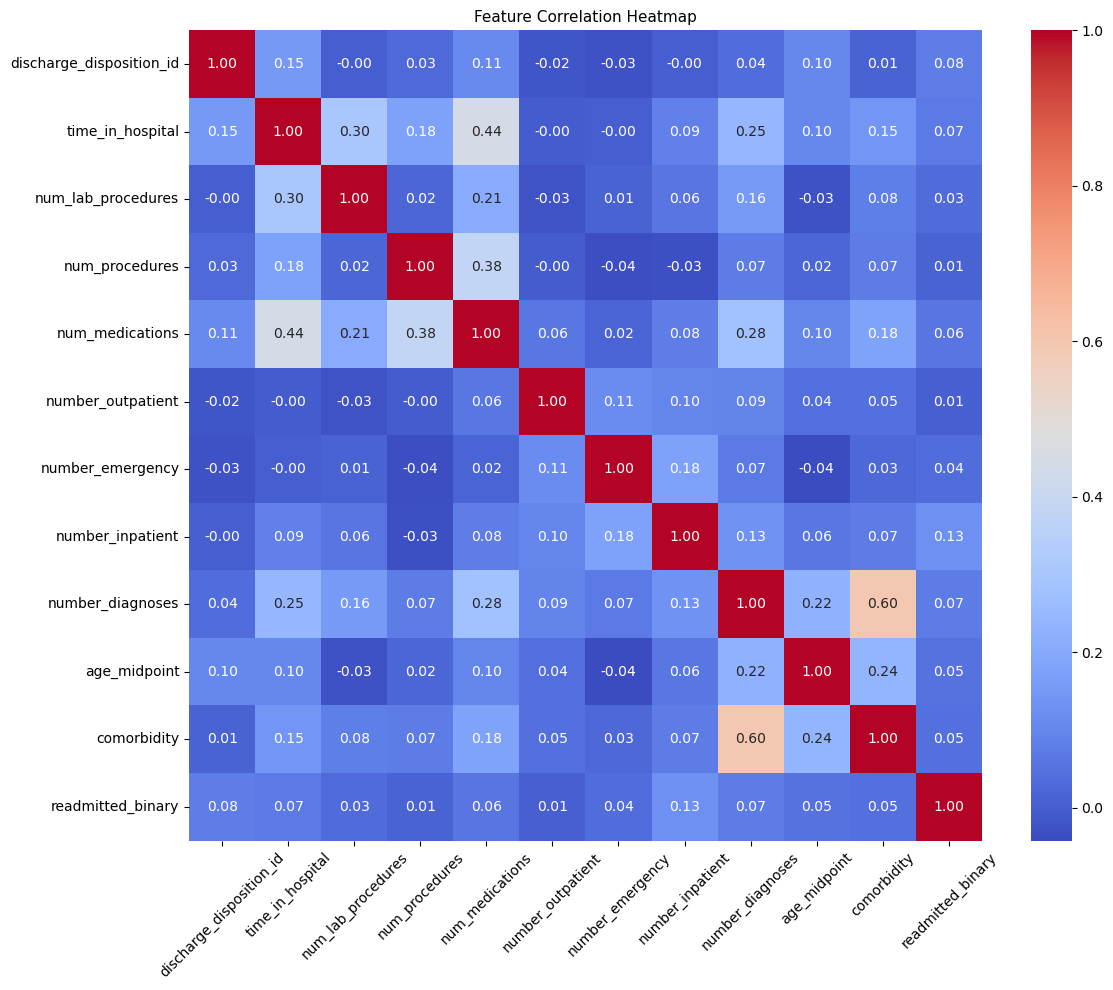

In [12]:
from eda_analyzer import EDAAnalyzer

# 选择你要分析的数据表
eda = EDAAnalyzer(df)  # 或 processed_data

# 1. readmission 分布
eda.plot_readmission_distribution()

# 2. 缺失值分布
eda.plot_missing_values()

# 1. 平均年龄
eda.plot_average_age()

# 2. 按年龄组画住院时长均值柱状图
eda.plot_avg_stay_by_age_group()

# 3. 按年龄组和性别画住院时长箱线图
eda.plot_avg_stay_by_age_gender_box()

# 4. 前10诊断分布
eda.plot_top_diagnoses_simple()

# 5. 特征相关性热力图
eda.plot_correlation_heatmap()


# 4. Medical interpretation

## 4.1 Readdmision rate with Age group & gender 

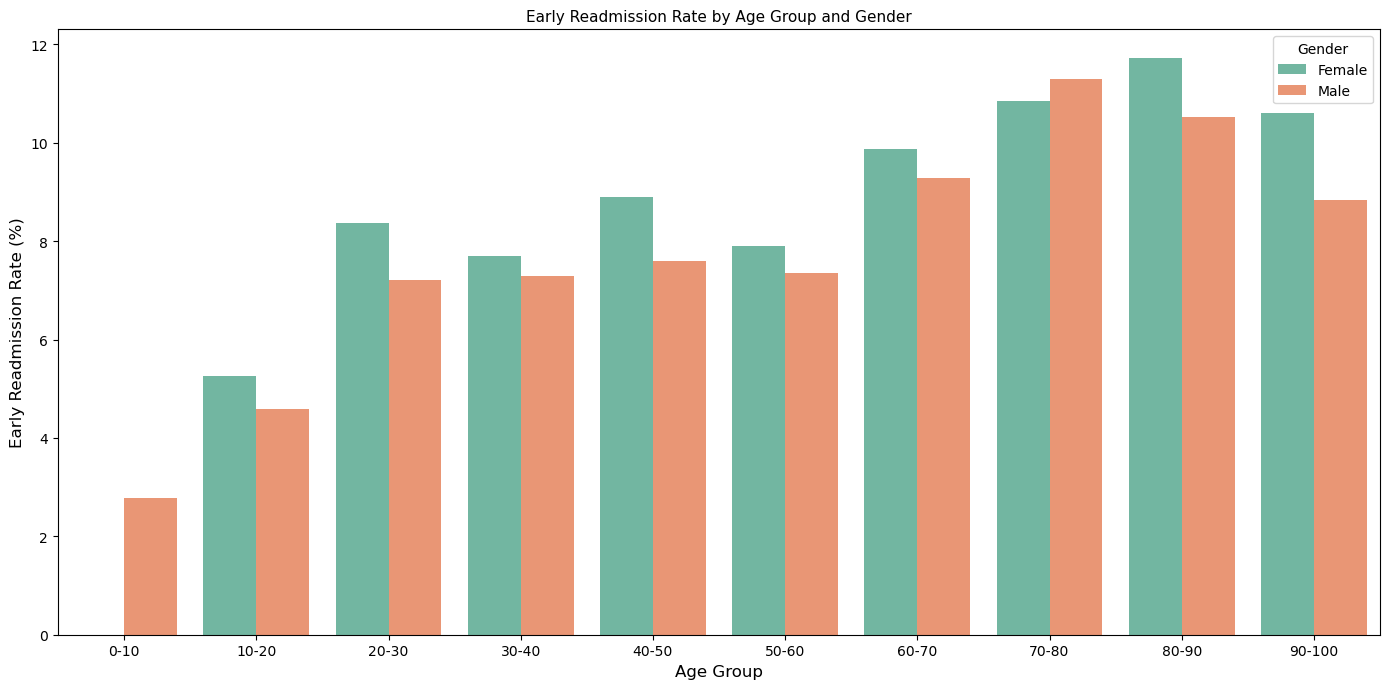

Readmission Rate Heatmap Table (age_group x gender_readmit):
gender_readmit  Early Readmission-Female  Early Readmission-Male  \
age_group                                                          
0-10                            0.000000                1.333333   
10-20                           2.982107                1.988072   
20-30                           5.257271                2.684564   
30-40                           4.309875                3.218767   
40-50                           4.341280                3.889586   
50-60                           3.950138                3.674923   
60-70                           4.920730                4.651511   
70-80                           5.944798                5.110707   
80-90                           7.166853                4.087346   
90-100                          7.572816                2.524272   

gender_readmit  No Early Readmission-Female  No Early Readmission-Male  
age_group                                        

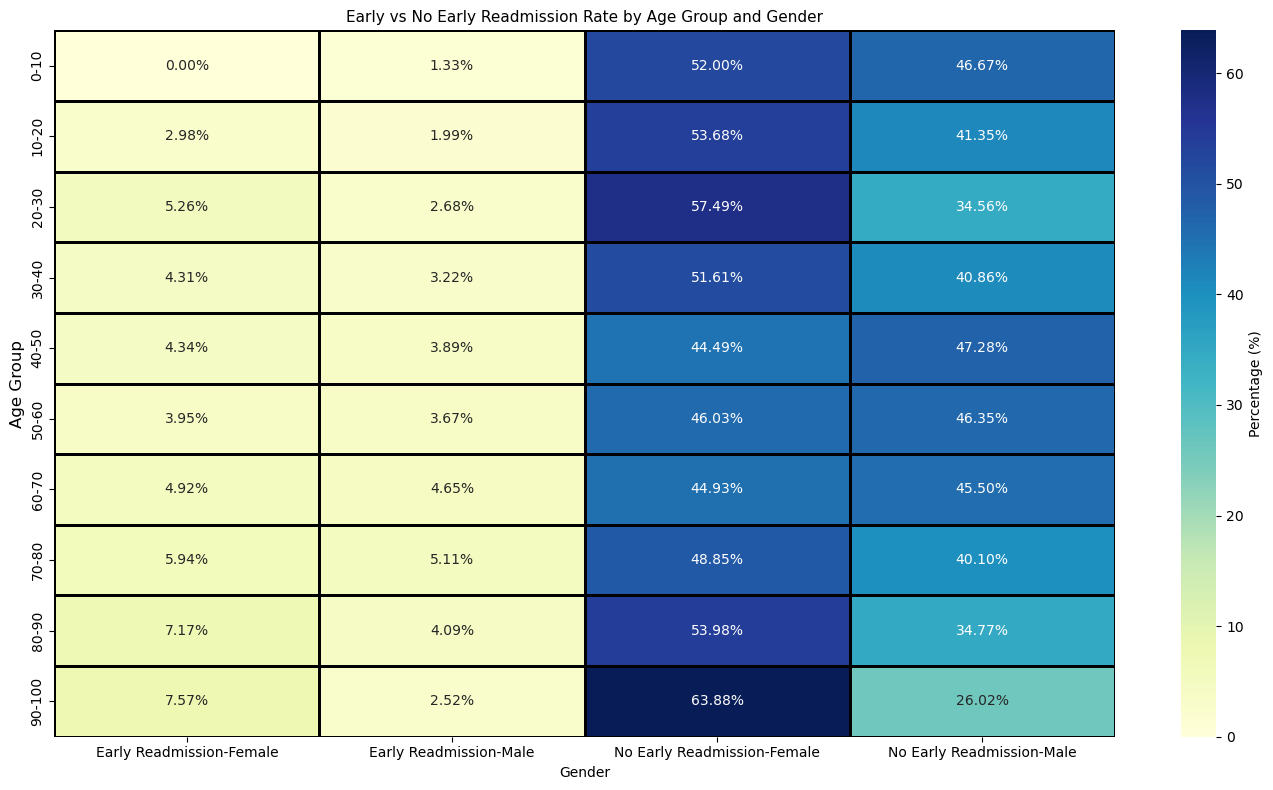

gender_readmit,Early Readmission-Female,Early Readmission-Male,No Early Readmission-Female,No Early Readmission-Male
age_group,,,,
0-10,0.000000,1.333333,52.000000,46.666667
10-20,2.982107,1.988072,53.677932,41.351889
20-30,5.257271,2.684564,57.494407,34.563758
30-40,4.309875,3.218767,51.609384,40.861975
40-50,4.341280,3.889586,44.491844,47.277290
50-60,3.950138,3.674923,46.025579,46.349361
60-70,4.920730,4.651511,44.929704,45.498056
70-80,5.944798,5.110707,48.847437,40.097058
80-90,7.166853,4.087346,53.975364,34.770437


In [13]:
# 统计并可视化不同年龄组和性别下的再入院率分布
eda.plot_readmission_rate_by_age_gender()

# 画age_group和gender下<30/>30 readmission rate的热力图
eda.plot_readmission_rate_heatmap_by_age_gender()



## 4.2  Relationship between comorbidities (e.g., diabetes, heart disease) and Readmission Rates

Readmission rate by comorbidity (%):
readmit_bin      Early Readmission Rate (%)  No Early Readmission Rate (%)
comorbidity                                                               
circulatory                        9.676350                      90.323650
diabetes                           9.206717                      90.793283
digestive                          7.510730                      92.489270
genitourinary                      8.755760                      91.244240
injuries                          14.529915                      85.470085
musculoskeletal                    9.830508                      90.169492
neoplasms                         13.740458                      86.259542
other                              8.124077                      91.875923
respiratory                        8.303249                      91.696751


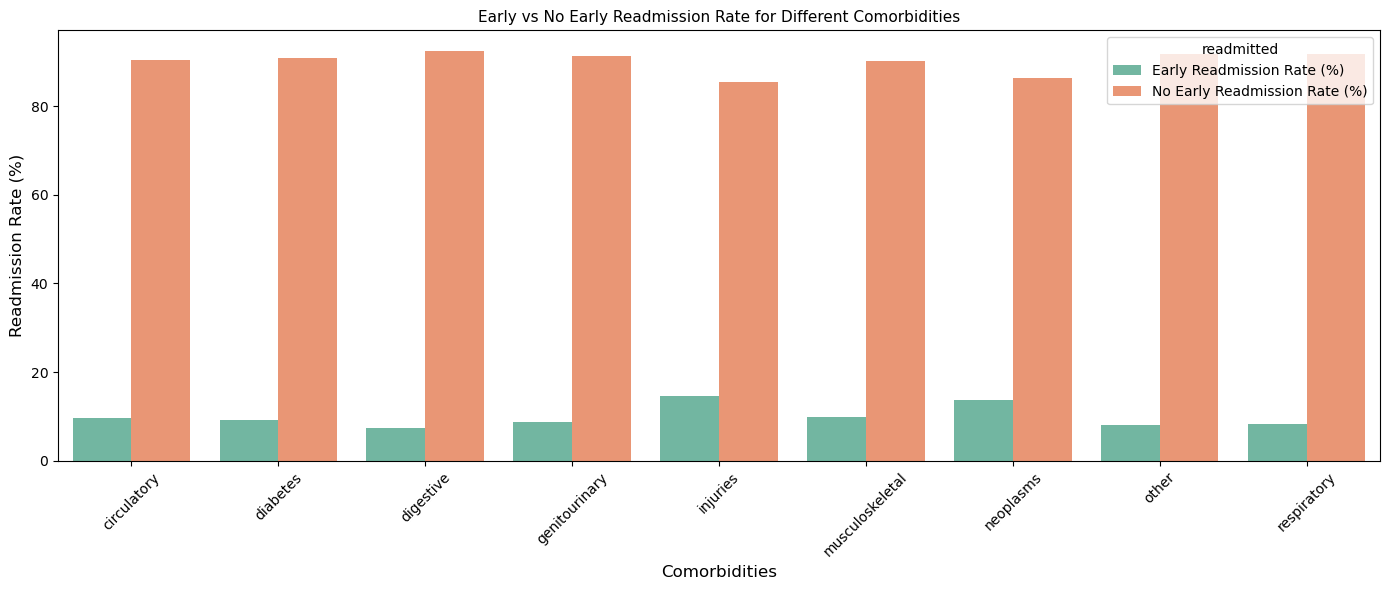

readmit_bin,comorbidity,Early Readmission Rate (%),No Early Readmission Rate (%)
0,circulatory,9.676350,90.323650
1,diabetes,9.206717,90.793283
2,digestive,7.510730,92.489270
3,genitourinary,8.755760,91.244240
4,injuries,14.529915,85.470085
5,musculoskeletal,9.830508,90.169492
6,neoplasms,13.740458,86.259542
7,other,8.124077,91.875923
8,respiratory,8.303249,91.696751


In [14]:
eda.plot_comorbidity_vs_readmission(preprocessor.icd9_to_nine_category)

## 4.3 Medication

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  18.518519
1                   glimepiride   Increased  35.135135
2                   glimepiride   No Change  18.861210
3                   glimepiride   Not Given  22.572655
4                     glipizide   Decreased  29.870130
5                     glipizide   Increased  22.807018
6                     glipizide   No Change  21.232418
7                     glipizide   Not Given  22.543876
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.438565
10                    glyburide   Decreased  22.972973
11                    glyburide   Increased  32.520325
12                    glyburide   No Change  22.527945
13                    glyburide   Not Given  22.314994
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   No Change  15.887850
16      

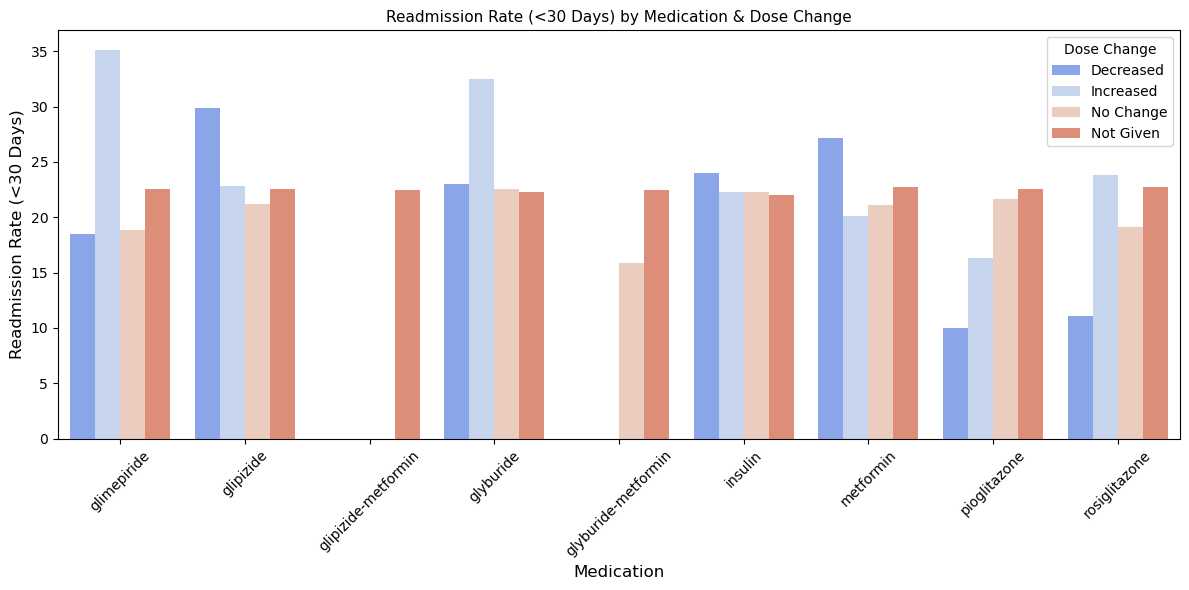

Readmission Rate (<30 Days) by Medication & Dose Change:
readmitted           Medication Dose Change        <30
0                   glimepiride   Decreased  18.518519
1                   glimepiride   Increased  35.135135
2                   glimepiride   No Change  18.861210
3                   glimepiride   Not Given  22.572655
4                     glipizide   Decreased  29.870130
5                     glipizide   Increased  22.807018
6                     glipizide   No Change  21.232418
7                     glipizide   Not Given  22.543876
8           glipizide-metformin   No Change        NaN
9           glipizide-metformin   Not Given  22.438565
10                    glyburide   Decreased  22.972973
11                    glyburide   Increased  32.520325
12                    glyburide   No Change  22.527945
13                    glyburide   Not Given  22.314994
14          glyburide-metformin   Decreased        NaN
15          glyburide-metformin   No Change  15.887850
16      

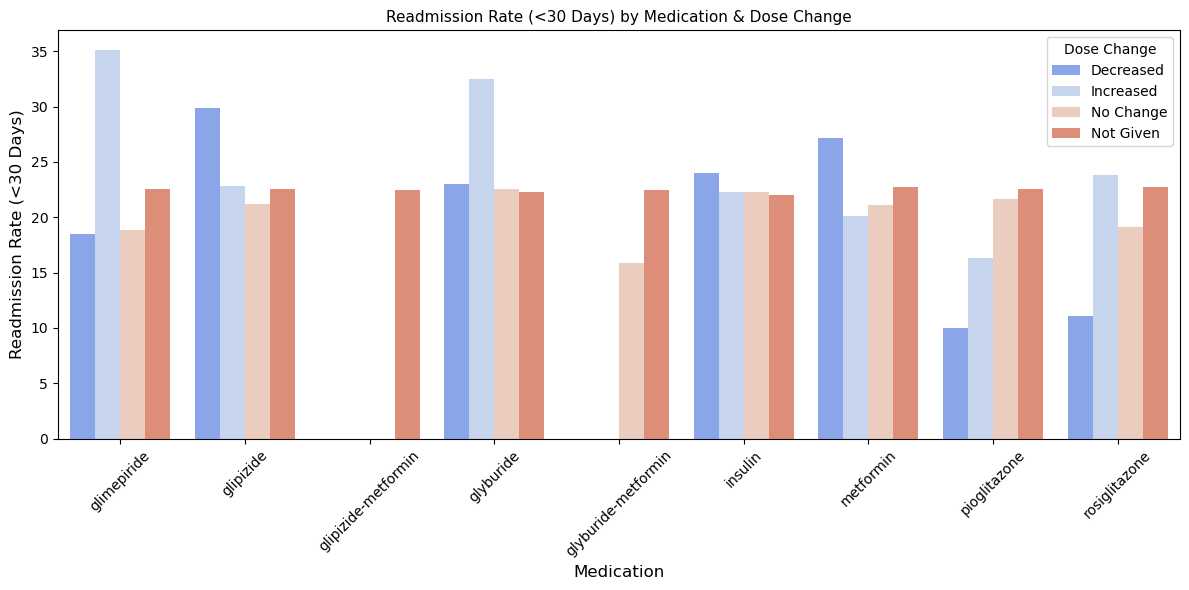

Readmission Rate (<30 Days) Heatmap Table:
Dose Change          Decreased  Increased  No Change  Not Given
Medication                                                     
glimepiride          18.518519  35.135135  18.861210  22.572655
glipizide            29.870130  22.807018  21.232418  22.543876
glipizide-metformin        NaN        NaN        NaN  22.438565
glyburide            22.972973  32.520325  22.527945  22.314994
glyburide-metformin        NaN        NaN  15.887850  22.486144
insulin              23.978780  22.320862  22.264631  22.053872
metformin            27.173913  20.134228  21.146245  22.755092
pioglitazone         10.000000  16.279070  21.627409  22.544928
rosiglitazone        11.111111  23.809524  19.141914  22.696839


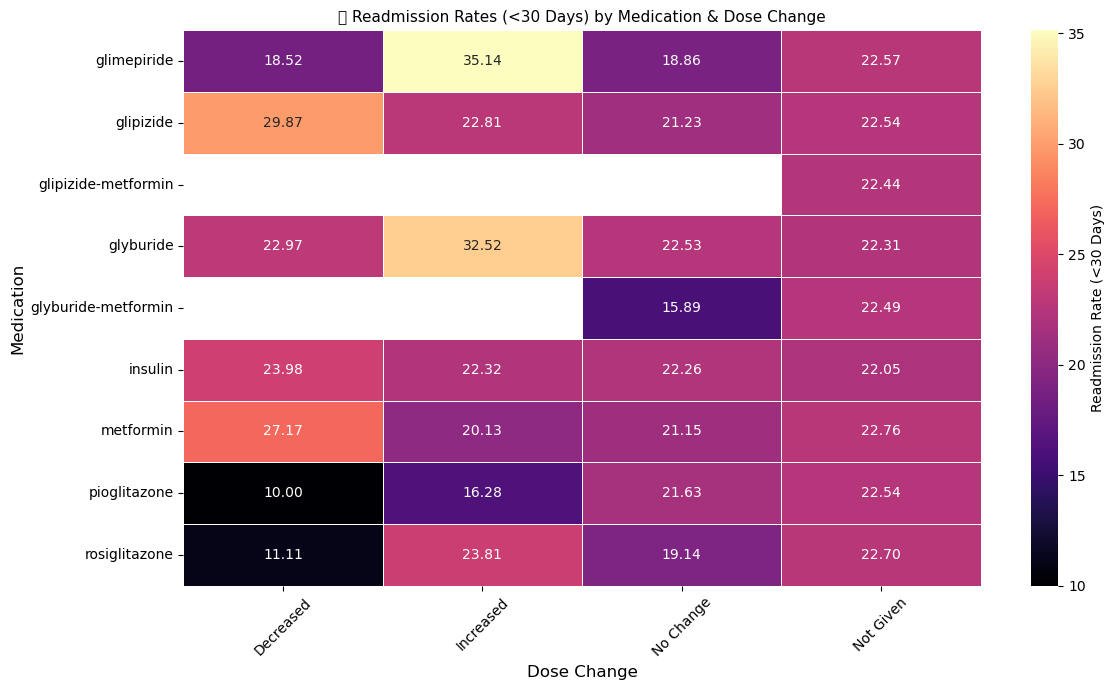

Dose Change,Decreased,Increased,No Change,Not Given
Medication,,,,
glimepiride,18.518519,35.135135,18.861210,22.572655
glipizide,29.870130,22.807018,21.232418,22.543876
glipizide-metformin,NaN,NaN,NaN,22.438565
glyburide,22.972973,32.520325,22.527945,22.314994
glyburide-metformin,NaN,NaN,15.887850,22.486144
insulin,23.978780,22.320862,22.264631,22.053872
metformin,27.173913,20.134228,21.146245,22.755092
pioglitazone,10.000000,16.279070,21.627409,22.544928
rosiglitazone,11.111111,23.809524,19.141914,22.696839


In [15]:


eda.plot_readmission_by_medication_and_dose()
# 热力图
eda.plot_readmission_by_medication_and_dose_heatmap()

# 5.Feature Engineering

## 5.1 Dataset division and encoding

In [16]:
# X_train, _, X_test, y_train, _, y_test = preprocessor.split_data(df)
# # 用X_test占位val参数
# X_train, _, X_test = preprocessor.encode_categorical_features(X_train, X_test, X_test)
# X_train, _, X_test = preprocessor.scale_numerical_features(X_train, X_test, X_test)

In [17]:
# 把是糖尿病的那一列及其category置为None（或np.nan），其它诊断信息全部保留。

def drop_diabetes_diag(row):
    for i in [1, 2, 3]:
        if is_diabetes(row[f'diag_{i}']):
            row[f'diag_{i}'] = None
            if f'diag_{i}_category' in row:
                row[f'diag_{i}_category'] = None
    return row

df = df.apply(drop_diabetes_diag, axis=1)

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(df)
X_train, X_val, X_test = preprocessor.encode_categorical_features(X_train, X_val, X_test)
X_train, X_val, X_test = preprocessor.scale_numerical_features(X_train, X_val, X_test)
X_train_balanced, y_train_balanced = preprocessor.apply_smote(X_train, y_train)
print(f'The number of samples in the training set after balancing: {X_train_balanced.shape[0]}')

INFO:data_preprocessor:Splitting data into train/validation/test sets...
INFO:data_preprocessor:Dropping unused ID and target columns before splitting: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'readmitted']
INFO:data_preprocessor:Data split - Train: (19781, 51), Val: (4946, 51), Test: (6182, 51)
INFO:data_preprocessor:Encoding categorical features using label encoding...
INFO:data_preprocessor:Scaling numerical features...
INFO:data_preprocessor:Applying SMOTE for class balancing...
INFO:data_preprocessor:Before SMOTE - Class distribution: {0: 17952, 1: 1829}
INFO:data_preprocessor:After SMOTE - Class distribution: {1: 17952, 0: 17952}


The number of samples in the training set after balancing: 35904


## 5.2 Top_N Feature selection

In [19]:
# ===============================================================
#          多Top N值特征选择与结果展示
# ===============================================================

# 1. 设置您想要测试的top_n值列表
top_n_list = [ 5,10,15]  # 您可以随意修改这个列表
print(f"将要测试的Top N值: {top_n_list}")

# 2. 创建特征选择器
selector = FeatureSelector()

# 3. 运行多个top_n值的特征选择
print("\n🚀 开始运行多个Top N值的特征选择...")
multiple_results = selector.select_features_multiple_topn(
    X_train_balanced, 
    y_train_balanced, 
    top_n_list
)
print("✅ 特征选择完成！")


from feature_selector import flatten_multiple_results
selected_features_dict = flatten_multiple_results(multiple_results)

# 5. (可选) 选择一组特征进行后续步骤
#    您可以根据上面的表格结果，选择一组最满意的特征
#    例如，选择top_n=10时，L1方法选择的特征
# ---------------------------------------------------------------
# chosen_top_n = 10
# chosen_method = 'L1'
# X_selected = X_train_balanced[multiple_results[chosen_top_n][chosen_method]]
# print(f"\n proceeding with top_n={chosen_top_n} and method='{chosen_method}'")
# print(f"Selected {len(X_selected.columns)} features.")

INFO:feature_selector:Running feature selection with multiple top_n values: [5, 10, 15]
INFO:feature_selector:Processing top_n = 5
INFO:feature_selector:Running all feature selection methods with top_n=5...
INFO:feature_selector:Selecting top 5 features using L1 regularization...


将要测试的Top N值: [5, 10, 15]

🚀 开始运行多个Top N值的特征选择...


INFO:feature_selector:L1 feature selection completed. Selected features: ['number_inpatient', 'age_group', 'number_diagnoses', 'miglitol', 'number_outpatient']
INFO:feature_selector:Selecting top 5 features using Mutual Information...
INFO:feature_selector:Mutual Information feature selection completed. Selected features: ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'diag_1', 'number_diagnoses']
INFO:feature_selector:Selecting top 5 features using Tree-based importance...
INFO:feature_selector:Tree-based feature selection completed. Selected features: ['discharge_disposition_desc', 'time_in_hospital', 'age_midpoint', 'age_group', 'age']
INFO:feature_selector:All feature selection methods completed
INFO:feature_selector:Processing top_n = 10
INFO:feature_selector:Running all feature selection methods with top_n=10...
INFO:feature_selector:Selecting top 10 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['numbe

✅ 特征选择完成！


## 5.3 Feature selection visualization


📊 Multiple Top N Value Feature Selection Detailed Results:


,Top N,Method,Selected Features
0,5,L1,"[number_inpatient, age_group, number_diagnoses, miglitol, number_outpatient]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, time_in_hospital, diag_1, number_diagnoses]"
2,5,TreeImportance,"[discharge_disposition_desc, time_in_hospital, age_midpoint, age_group, age]"
3,10,L1,"[number_inpatient, age_group, number_diagnoses, miglitol, number_outpatient, metformin, time_in_..."
4,10,MutualInfo,"[num_lab_procedures, num_medications, time_in_hospital, diag_1, number_diagnoses, age_midpoint, ..."
5,10,TreeImportance,"[discharge_disposition_desc, time_in_hospital, age_midpoint, age_group, age, number_inpatient, n..."
6,15,L1,"[number_inpatient, age_group, number_diagnoses, miglitol, number_outpatient, metformin, time_in_..."
7,15,MutualInfo,"[num_lab_procedures, num_medications, time_in_hospital, diag_1, number_diagnoses, age_midpoint, ..."
8,15,TreeImportance,"[discharge_disposition_desc, time_in_hospital, age_midpoint, age_group, age, number_inpatient, n..."


INFO:feature_selector:Found 3 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 8 features selected by at least 2 methods
INFO:feature_selector:Found 3 features selected by at least 3 methods
INFO:feature_selector:Found 15 features selected by at least 2 methods
INFO:feature_selector:Found 7 features selected by at least 3 methods



🔍 Common Features Summary by Top N Value:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,"[age_group, number_diagnoses, time_in_hospital]",[]
1,10,"[number_inpatient, age_group, number_diagnoses, time_in_hospital, admission_source_desc, num_med...","[age_group, number_diagnoses, time_in_hospital]"
2,15,"[number_inpatient, age_group, number_diagnoses, time_in_hospital, admission_source_desc, num_med...","[age_group, number_diagnoses, time_in_hospital, num_medications, num_procedures, medical_special..."



🎨 Generating Feature Selection Matrix Visualization Chart:


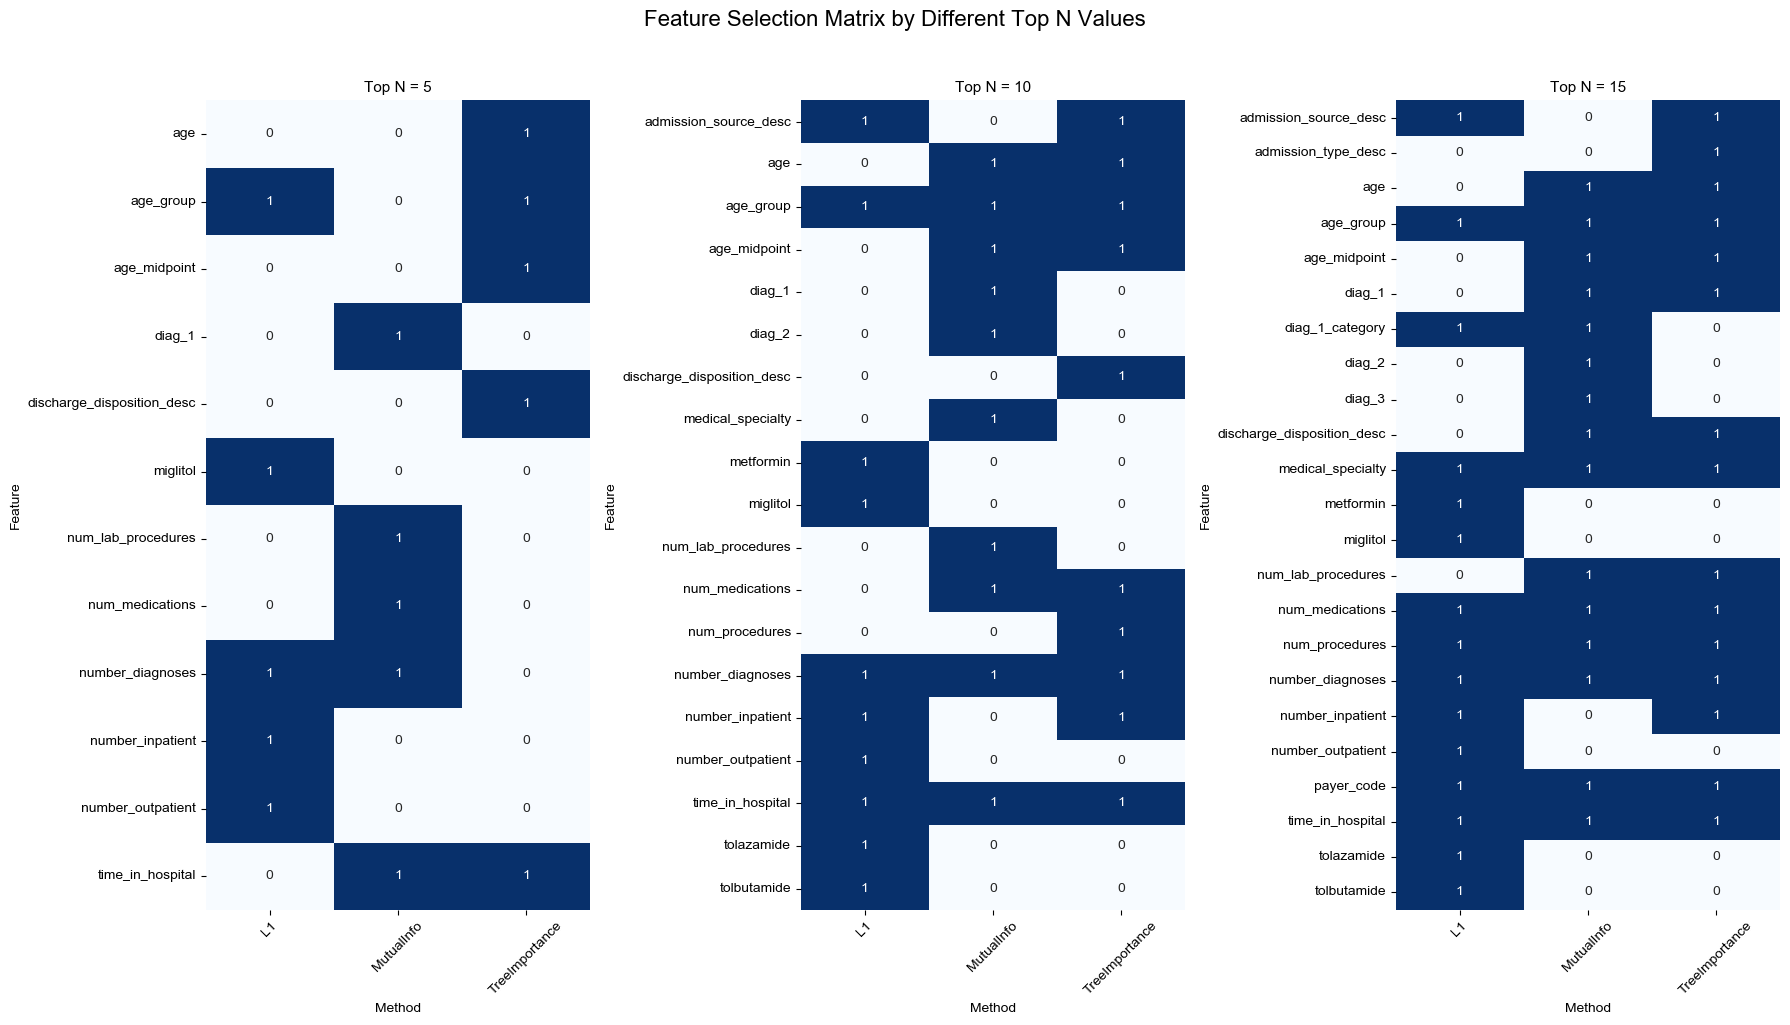

In [20]:

# 4. 以表格形式显示结果
selector.display_multiple_topn_results(multiple_results)

# 5. [新增] 可视化特征选择矩阵
selector.plot_feature_selection_matrix(multiple_results)

# ============

# 6. Model training and evaluation

In [21]:
# here is the defalt setting of model taining
# # 查阅model_trainer.py的get_models()方法，你当前的模型参数是默认的，具体如下：
# •	LogisticRegression:
# •	solver='liblinear'
# •	random_state=42
# •	其余参数默认（如C=1.0）
# •	RandomForestClassifier:
# •	n_estimators=100
# •	random_state=42
# •	其余参数默认（如max_depth=None）
# •	XGBoost (XGBClassifier):
# •	eval_metric='logloss'
# •	random_state=42
# •	其余参数默认（如n_estimators=100, learning_rate=0.3）
# 没有做超参数调优（grid search），只是用了一组固定参数。


# feature_selectors = selector.get_feature_selectors() 

# feature_sets = {}
# for top_n in top_n_list:
#     feature_sets[top_n] = {}
#     for fs_name, fs_func in feature_selectors.items():
#         features = fs_func(X_train_balanced, y_train_balanced, top_n=top_n)
#         feature_sets[top_n][fs_name] = features
           
# model_trainer = ModelTrainer()
# results_df = model_trainer.evaluate_all_combinations_on_val_and_test(
#     feature_sets, X_train, y_train, X_val, y_val, X_test, y_test
# )
# display(results_df)


In [22]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'discharge_disposition_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_disposition_desc',
       'admission_source_desc', 'age_midpoint', 'age_group', 'diag_1_category',
       'diag_2_category', 'diag_3_category'

In [25]:
# 导入必要的包
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import os

# 设置参数（这些保留在notebook中便于修改）
fs_names = ['L1', 'MutualInfo', 'TreeImportance']
top_n = 15
cv_folds = 5  # 可以改成5

# 定义模型和参数网格
model_classes = {
    'RandomForest': RandomForestClassifier,
    'LogisticRegression': LogisticRegression,
    'XGBoost': XGBClassifier
}

# # 精简版本 第一次
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 500],
        'max_depth': [None,  10, 20],
        'min_samples_split': [2,  10],
        'min_samples_leaf': [1,  4],
        
        

    },
    'LogisticRegression': {
        'C': [ 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000]
    },
    'XGBoost': {
        'n_estimators': [100, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3,  7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8,  1.0]
    }
}



# 第二次调参

# param_grids = {
#     'RandomForest': {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [None, 20, 30, 40],
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1, 2, 3]
#     },
#     'LogisticRegression': {
#     'C': [0.05, 0.1, 0.2, 0.5, 1],
#     'solver': ['liblinear', 'saga'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [100, 300],
#     'learning_rate': [0.05, 0.07, 0.13],
#     'max_depth': [6,  8],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     # 'reg_alpha': [0, 0.1],
#     # 'reg_lambda': [0]
#     }
# }

# # 第三次调参 取消，因为发现第二次的不如第一次的好
# param_grids = {
#     'RandomForest': {
#     'n_estimators': [500, 550, 600, 650],
#     'max_depth': [25, 30, 35, None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
#     },
#     'LogisticRegression': {
#     'C': [0.01, 0.03, 0.05, 0.07, 0.1],
#     'solver': ['liblinear'],
#     'penalty': ['l1'],
#     'max_iter': [1000]
#     },
#     'XGBoost': {
#     'n_estimators': [200, 250,300],
#     'learning_rate': [ 0.04, 0.05, 0.06, 0.07],
#     'max_depth': [7,10],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [ 0.8, 0.85, 0.9],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [0,0.1]
#     }
# }


In [26]:

# 调用py文件中的方法
model_trainer = ModelTrainer()
all_val_results, all_test_results, all_cv_results_list = model_trainer.run_grid_search_for_all_fs_methods(
    fs_names=fs_names,
    top_n=top_n,
    selected_features_dict=selected_features_dict,
    model_classes=model_classes,
    param_grids=param_grids,
    X_train_balanced=X_train_balanced,
    y_train_balanced=y_train_balanced,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    cv_folds=cv_folds
)

# 保存到Excel（这部分保留在notebook中便于修改）
excel_path = 'sensitivity_diabetes_diag_all_param_search_results_gridcv.xlsx'
mode = 'a' if os.path.exists(excel_path) else 'w'

with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
    for i, fs_name in enumerate(fs_names):
        val_df = all_val_results[i]
        test_df = all_test_results[i]
        cv_df = all_cv_results_list[i]
        
        val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
        test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
        cv_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)
        
        print(f"{fs_name} 结果已保存到 {excel_path}")

print("所有GridSearchCV结果已保存完成！")


Grid search for L1 - RandomForest ...


Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for L1 - LogisticRegression ...
Best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Grid search for L1 - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
L1 GridSearchCV completed

Grid search for MutualInfo - RandomForest ...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Grid search for MutualInfo - LogisticRegression ...
Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

Grid search for MutualInfo - XGBoost ...
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
MutualInfo GridSearchCV completed

Grid search for TreeImportance - RandomForest ...
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split'

## L1

In [ ]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'L1'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## MutualInfo

In [ ]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'MutualInfo'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")

## TreeImportance

In [ ]:
# # 原型代码，循环

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score, f1_score
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# import os

# fs_name = 'TreeImportance'  # 或 'MutualInfo', 'TreeImportance'
# top_n = 15
# feature_list = selected_features_dict[(top_n, fs_name)]



# val_results = []
# test_results = []
# all_cv_results_list = []

# for model_name, model_cls in model_classes.items():
#     print(f"\nGrid search for {model_name} ...")
#     grid = GridSearchCV(
#         estimator=model_cls(),
#         param_grid=param_grids[model_name],
#         scoring='roc_auc',
#         cv=3,  # 你可以改成5
#         n_jobs=-1,
#         return_train_score=False
#     )
#     grid.fit(X_train_balanced[feature_list], y_train_balanced)
#     best_params = grid.best_params_
#     print("Best params:", best_params)
#     all_cv_results = pd.DataFrame(grid.cv_results_)
#     all_cv_results['model'] = model_name
#     all_cv_results['fs'] = fs_name
#     all_cv_results['top_n'] = top_n
#     all_cv_results_list.append(all_cv_results)
#     y_val_pred = grid.best_estimator_.predict(X_val[feature_list])
#     y_val_prob = grid.best_estimator_.predict_proba(X_val[feature_list])[:, 1]
#     val_auc = roc_auc_score(y_val, y_val_prob)
#     val_f1 = f1_score(y_val, y_val_pred)
#     val_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'val_auc': val_auc,
#         'val_f1': val_f1
#     })
#     y_test_pred = grid.best_estimator_.predict(X_test[feature_list])
#     y_test_prob = grid.best_estimator_.predict_proba(X_test[feature_list])[:, 1]
#     test_auc = roc_auc_score(y_test, y_test_prob)
#     test_f1 = f1_score(y_test, y_test_pred)
#     test_results.append({
#         'model': model_name,
#         'fs': fs_name,
#         'top_n': top_n,
#         **best_params,
#         'test_auc': test_auc,
#         'test_f1': test_f1
#     })


# val_df = pd.DataFrame(val_results)
# test_df = pd.DataFrame(test_results)
# all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

# excel_path = 'all_param_search_results_gridcv.xlsx'
# mode = 'a' if os.path.exists(excel_path) else 'w'
# with pd.ExcelWriter(excel_path, mode=mode, if_sheet_exists='replace' if mode=='a' else None) as writer:
#     val_df.to_excel(writer, sheet_name=f'{fs_name}_val', index=False)
#     test_df.to_excel(writer, sheet_name=f'{fs_name}_test', index=False)
#     all_cv_results_df.to_excel(writer, sheet_name=f'{fs_name}_cv', index=False)

# print(f"GridSearchCV所有参数组合、val和test最优结果已保存到 {excel_path} 的 sheet: {fs_name}_cv, {fs_name}_val, {fs_name}_test")